# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cases_root_dir = Path('cases')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
samples_cases = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
cases_paths = [cases_root_dir / f'case-{x}' for x in samples_cases]

metadata_file = Path('input/metadata-subsample-pangolin.tsv')

# 2. Indexing

## 2.1. Samples comparison

In [2]:
from typing import List

index_info_paths = [x / 'index-info.tsv' for x in cases_paths]
index_info_paths = [x for x in index_info_paths if x.exists()]

def read_all_df(index_paths: List[Path]) -> pd.DataFrame:
    dfs = []
    for index in index_paths:
        dfs.append(pd.read_csv(index, sep='\t'))
        
    return pd.concat(dfs).reset_index(drop=True)

index_info_df = read_all_df(index_info_paths)
index_info_df['Samples'] = index_info_df['Name'].str.extract(r'^case-(\d+)').astype(int)
index_info_df['Number features (unknown)'] = index_info_df['Number features (all)'] - \
                                             index_info_df['Number features (no unknown)']
index_info_df[
    'Percent of reference genome with unknown/missing features'] = 100 * (index_info_df[
    'Number features (unknown)'] / index_info_df['Reference length'])
index_info_df.head(5)

,Name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),Analysis memory (max/process),...,Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples,Number features (unknown),Percent of reference genome with unknown/missing features
0,case-10,1,10,2900,44,32,29903,139.78,1.429692e+09,377692160.0,...,234856448.0,761856.0,92.58,249139200.0,219570176.0,237.23,5.391446e+09,10,2856,9.550881
1,case-10,2,10,2900,44,32,29903,138.50,1.448071e+09,368533504.0,...,235270144.0,757760.0,82.70,249458688.0,220327936.0,225.89,5.393736e+09,10,2856,9.550881
2,case-10,3,10,2900,44,32,29903,139.58,1.444766e+09,380194816.0,...,234606592.0,761856.0,82.05,248881152.0,219791360.0,226.14,5.389349e+09,10,2856,9.550881
3,case-20,1,20,11560,61,32,29903,137.43,1.815732e+09,366129152.0,...,271831040.0,1957888.0,114.02,241582080.0,220491776.0,258.05,5.498565e+09,20,11499,38.454336
4,case-20,2,20,11560,61,32,29903,156.56,1.670365e+09,371167232.0,...,267173888.0,1961984.0,118.27,240123904.0,220340224.0,281.66,5.496709e+09,20,11499,38.454336


### 2.1.1. Common styles 

In [3]:
stages_palette = ['#1b9e77', '#7570b3', '#d95f02', '#000000']
stages_markers = ['o', 's', '^', 'X']
stages_palette_nototal = ['#1b9e77', '#7570b3', '#d95f02']
stages_markers_nototal = ['o', 's', '^']
stages_palette_notree = ['#1b9e77', '#7570b3', '#000000']
stages_markers_notree = ['o', 's', 'X']

### 2.1.2. Runtime plots

In [4]:
from typing import Callable

def melt_runtimes(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    if include_tree_na:
        df = df[~df['Tree runtime'].isna()]
        value_vars = ['Analysis runtime', 'Index runtime', 'Tree runtime', 'Total runtime']
    else:
        df['Total runtime'] = df['Analysis runtime'] + df['Index runtime']
        value_vars = ['Analysis runtime', 'Index runtime', 'Total runtime']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df = df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' runtime', '', regex=False)
    df['Time (minutes)'] = df['Time (seconds)'] / 60
    df['Time (hours)'] = df['Time (seconds)'] / 3600
    return df

def melt_and_combine_with_without_tree(df: pd.DataFrame, melt_func: Callable[[pd.DataFrame, bool, str], pd.DataFrame],
                                      id_vars: str) -> pd.DataFrame:
    tree_df = melt_func(index_info_df, include_tree_na=True, id_vars=id_vars)
    tree_df['Type'] = 'Include Tree'
    ntree_df = melt_func(index_info_df, include_tree_na=False, id_vars=id_vars)
    ntree_df['Type'] = 'Exclude Tree'
    
    return pd.concat([tree_df, ntree_df])

In [5]:
index_info_runtime_df = melt_and_combine_with_without_tree(index_info_df,
                                                           melt_func=melt_runtimes,
                                                           id_vars='Samples')
index_info_runtime_df

,Samples,Stage,Time (seconds),Time (minutes),Time (hours),Type
0,10,Analysis,139.78,2.329667,0.038828,Include Tree
1,10,Analysis,138.50,2.308333,0.038472,Include Tree
2,10,Analysis,139.58,2.326333,0.038772,Include Tree
3,20,Analysis,137.43,2.290500,0.038175,Include Tree
4,20,Analysis,156.56,2.609333,0.043489,Include Tree
...,...,...,...,...,...,...
94,10000,Total,4468.69,74.478167,1.241303,Exclude Tree
95,10000,Total,4534.87,75.581167,1.259686,Exclude Tree
96,20000,Total,9064.83,151.080500,2.518008,Exclude Tree
97,20000,Total,9265.24,154.420667,2.573678,Exclude Tree


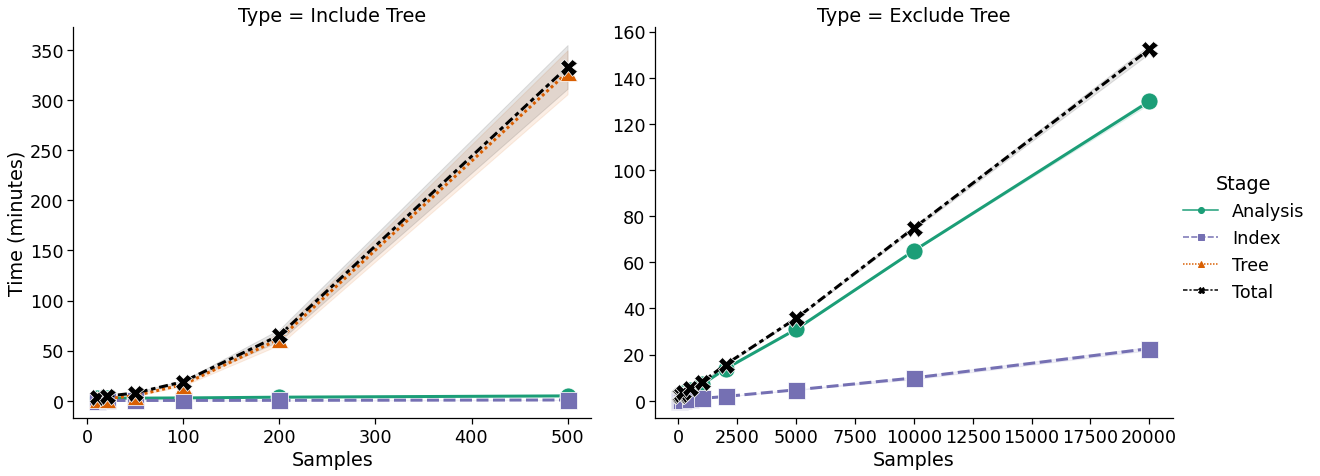

In [6]:
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Samples', y='Time (minutes)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_runtime_df, col="Type", markers=stages_markers, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-runtime.pdf')

### 2.1.3. Analysis memory plots

In [7]:
def melt_memory(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    if include_tree_na:
        df = df[~df['Tree memory (max)'].isna()]
        value_vars = ['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)']
    else:
        value_vars = ['Analysis memory (max)', 'Index memory (max)']

    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Peak Memory (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' memory (max)', '', regex=False)
    return df

In [8]:
index_info_memory_df = melt_and_combine_with_without_tree(index_info_df,
                                                          melt_func=melt_memory,
                                                          id_vars='Samples')
index_info_memory_df

,Samples,Stage,Peak Memory (GB),Type
0,10,Analysis,1.331505,Include Tree
1,10,Analysis,1.348621,Include Tree
2,10,Analysis,1.345543,Include Tree
3,20,Analysis,1.691032,Include Tree
4,20,Analysis,1.555649,Include Tree
...,...,...,...,...
61,10000,Index,27.548969,Exclude Tree
62,10000,Index,27.235210,Exclude Tree
63,20000,Index,33.660168,Exclude Tree
64,20000,Index,33.647835,Exclude Tree


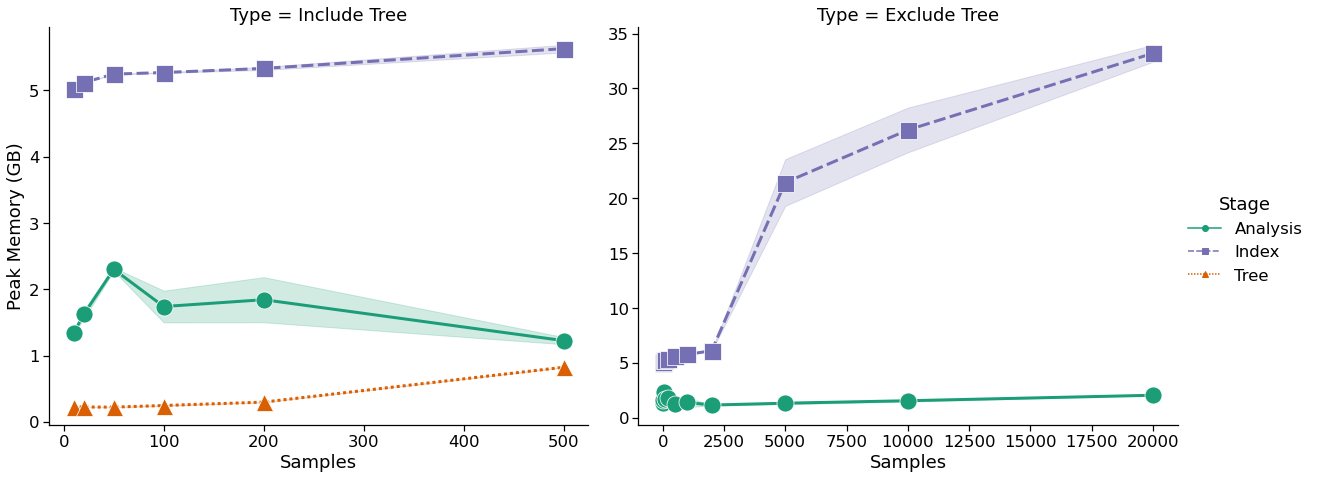

In [9]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Samples', y='Peak Memory (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_memory_df, markers=stages_markers_nototal, estimator='mean', col="Type",
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.2},
                    palette=stages_palette_nototal,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-memory.pdf')

#### 2.1.3.1. Number of features vs memory

In [10]:
# memory_features_df = melt_memory(index_info_df,
#                                             include_tree_na=False,
#                                             id_vars=['Samples',
#                                                      'Number features (no unknown)'])
# memory_features_df = memory_features_df.rename({'Number features (no unknown)': 'Number of features'}, axis='columns')
# memory_features_df['Feature Type'] = 'Variant calls'

memory_unknown_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (unknown)'])
memory_unknown_features_df = memory_unknown_features_df.rename({'Number features (unknown)': 'Number of features'}, axis='columns')
memory_unknown_features_df['Feature Type'] = 'Unknown/missing'

memory_all_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (all)'])
memory_all_features_df = memory_all_features_df.rename({'Number features (all)': 'Number of features'}, axis='columns')
memory_all_features_df['Feature Type'] = 'All'

memory_features_combined_df = pd.concat([memory_unknown_features_df, memory_all_features_df])
memory_features_combined_df = memory_features_combined_df[memory_features_combined_df['Stage'] == 'Index']
memory_features_combined_df['Number of samples'] = memory_features_combined_df['Samples']
memory_features_combined_df.loc[memory_features_combined_df['Samples'] <= 2000, 'Number of samples'] = '≤ 2000'

memory_features_combined_df.tail(10)

,Samples,Number of features,Stage,Peak Memory (GB),Feature Type,Number of samples
56,2000,32480,Index,6.111019,All,≤ 2000
57,5000,35646,Index,20.335629,All,5000
58,5000,35646,Index,20.074112,All,5000
59,5000,35646,Index,23.888672,All,5000
60,10000,39068,Index,23.872482,All,10000
61,10000,39068,Index,27.548969,All,10000
62,10000,39068,Index,27.235210,All,10000
63,20000,45667,Index,33.660168,All,20000
64,20000,45667,Index,33.647835,All,20000
65,20000,45667,Index,32.315666,All,20000


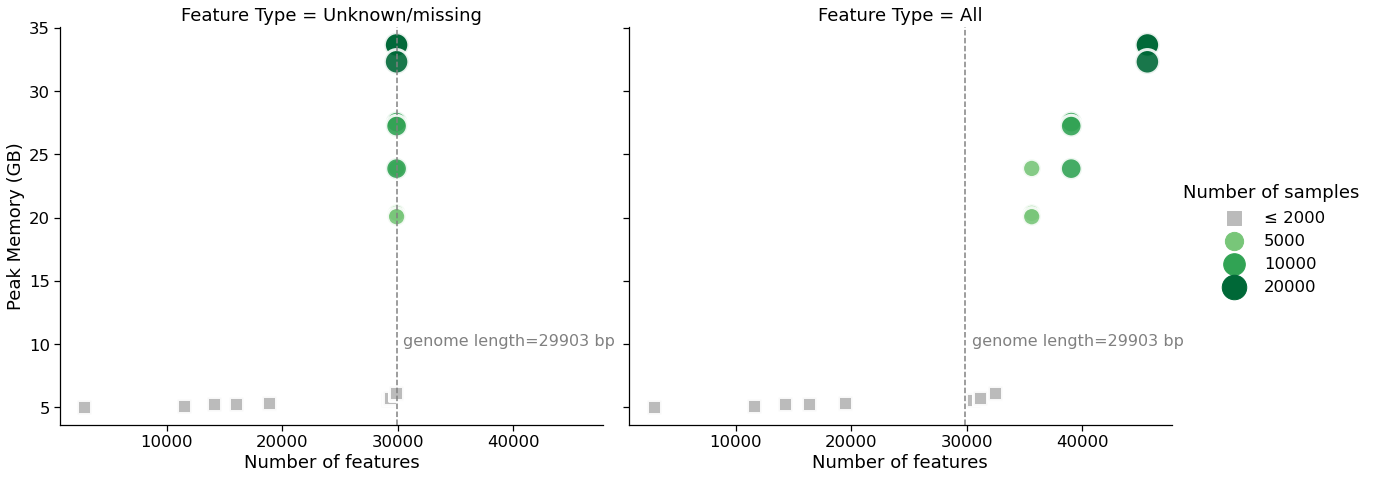

In [11]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number of features', y='Peak Memory (GB)', col="Feature Type",
                    size='Number of samples', style='Number of samples',
                    kind="scatter", s=100, alpha=0.9, hue='Number of samples',
                    sizes=(600, 200), palette=['#bbbbbb', '#78c679', '#31a354', '#006837'],
                    data=memory_features_combined_df, markers=["s", "o", "o", "o"],
                    height=7, aspect=1.2, linewidth=3,
                    )
    
    reference_size = index_info_df['Reference length'].value_counts().index[0]
    for ax in g.axes.flat:
        ax.axvline(reference_size, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.8
        xpos = reference_size + reference_size * 0.02
        ax.text(xpos, ypos, f'genome length={reference_size} bp', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/index-memory-features.pdf')

### 2.1.4. Disk usage plots

In [12]:
def melt_disk_usage(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    df['Total size'] = df['Analysis disk uage'] + df['Index size']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=['Analysis disk uage', 'Index size', 'Total size'])
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' disk uage', '', regex=False)
    df['Stage'] = df['Stage'].str.replace(' size', '', regex=False)
    return df
index_info_disk_df = melt_disk_usage(index_info_df, id_vars='Samples')
index_info_disk_df.head(3)

,Samples,Stage,Disk (GB)
0,10,Analysis,3.214535
1,10,Analysis,3.214535
2,10,Analysis,3.214535


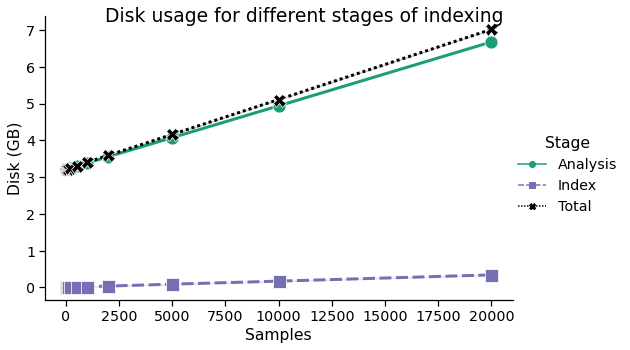

In [13]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Disk (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_disk_df, markers=stages_markers_notree, estimator='mean',
                    palette=stages_palette_notree,
                    height=5, aspect=1.5, linewidth=3, markersize=13, err_kws={"alpha": 0.2})
    g.fig.suptitle("Disk usage for different stages of indexing")
    plt.savefig('figures/index-disk-usage.pdf')

# 3. Querying

## 3.1. Querying API

In [14]:
query_paths = [x / 'query-api.tsv' for x in cases_paths]
query_paths = [x for x in query_paths if x.exists()]

query_df = read_all_df(query_paths)
query_df['Samples'] = query_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
query_df['Number of features (thousands)'] = query_df['Number features (all)'] / 1000
query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')

# Remove isin queries to ignore queries involving a tree
query_df = query_df[~query_df['Kind'].str.contains('isin')]

# Remove db.samples_query since I don't really need the times
query_df = query_df[~query_df['Kind'].str.contains('db.samples_query')]

# Divide up kinds of queries into classes
query_df['Time scale'] = 'Short'
query_df.loc[query_df['Kind'].isin(
    ['q.toframe', 'q.hasa', 'q.join', 'q.features_summary']), 'Time scale'] = 'Medium'
query_df.loc[query_df['Kind'].isin(
    ['q.features_comparison']), 'Time scale'] = 'Long'

query_df = query_df.sort_values('Time scale', ascending=False)

query_df.head(5)

,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Samples,Number of features (thousands),Time scale
600,case-500,q.isa,500,1396,30529,1000,1,0.387167,500,30.529,Short
616,case-500,q AND r,500,1396,30529,10000,7,0.021841,500,30.529,Short
638,case-500,q.summary,500,1396,30529,1000,9,0.373013,500,30.529,Short
637,case-500,q.summary,500,1396,30529,1000,8,0.365534,500,30.529,Short
636,case-500,q.summary,500,1396,30529,1000,7,0.359253,500,30.529,Short


### 3.1.1. Compare runtime for single set of samples

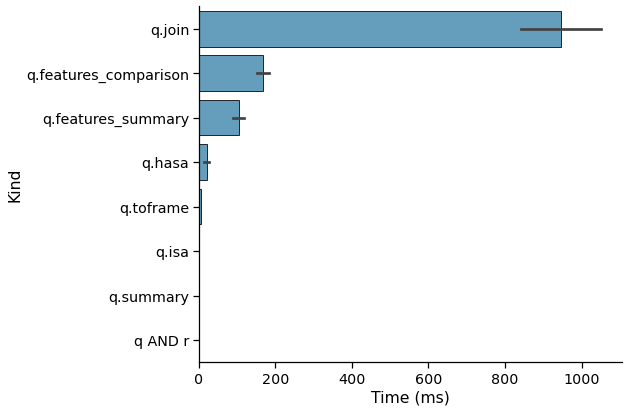

In [15]:
query_samples = query_df[query_df['Samples'] == 100]
query_samples = query_samples.sort_values('Time (ms)', ascending=False)
query_samples

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_samples, kind="bar",
        y="Kind", x="Time (ms)", hue=None,
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )
    plt.savefig('figures/query-api-runtime-100.pdf')

### 3.1.2. Compare runtime vs. all samples

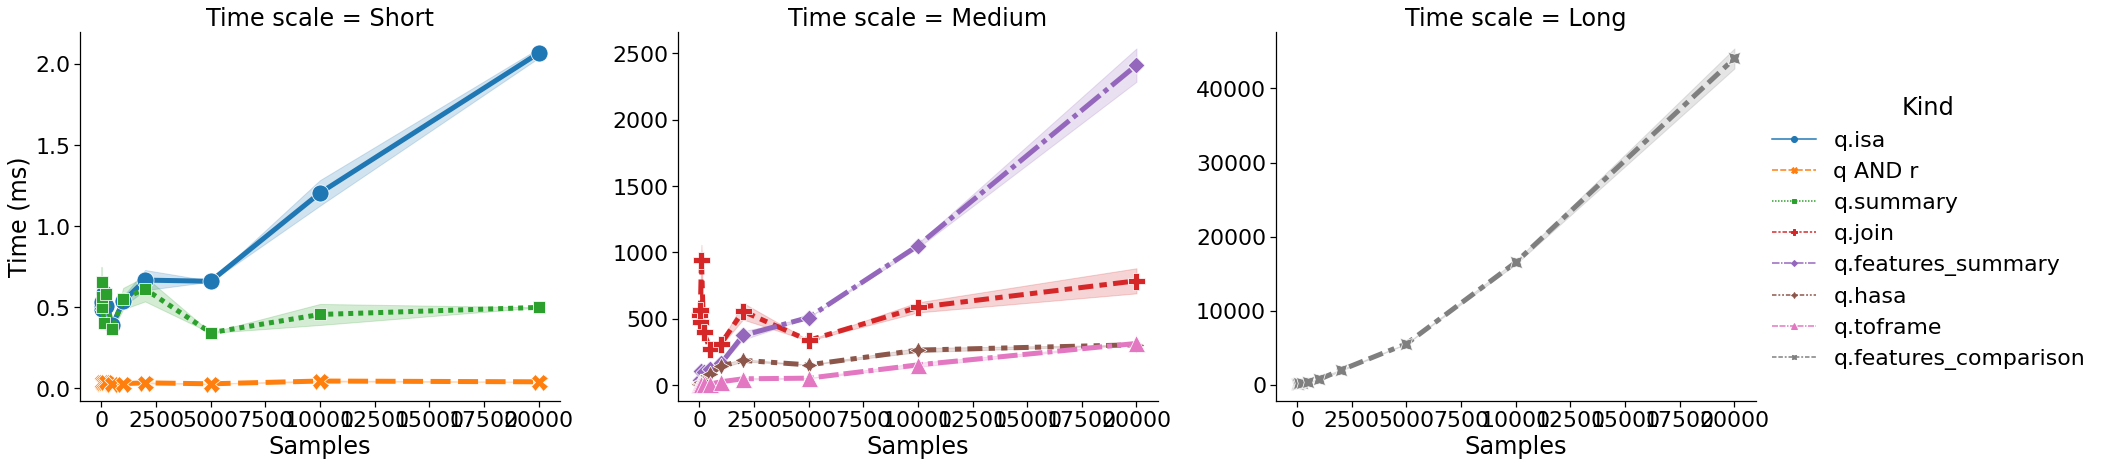

In [16]:
with sns.plotting_context("notebook", font_scale=2):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=7, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-runtime.pdf')

### 3.1.3. Compare runtime vs. number of features

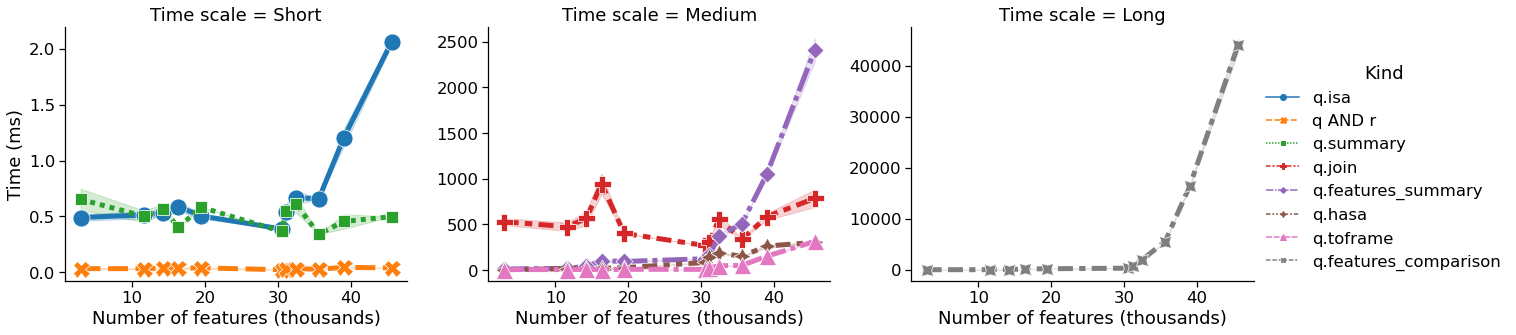

In [17]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", style="Kind",
                    ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=5, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-runtime-features.pdf')

## 3.2. Querying CLI

In [18]:
query_paths_cli = [x / 'query-cli.tsv' for x in cases_paths]
query_paths_cli = [x for x in query_paths_cli if x.exists()]
query_cli_df = read_all_df(query_paths_cli)
query_cli_df['Samples'] = query_cli_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_cli_df['Time (ms)'] = query_cli_df['Runtime'].apply(lambda x: x * 1000)
query_cli_df['Memory (MB)'] = query_cli_df['Memory (max)'].apply(lambda x: x / (1024**2))
query_cli_df['Number of features (thousands)'] = query_cli_df['Number features (all)'] / 1000
query_cli_df['Number of unknown features (thousands)'] = (query_cli_df['Number features (all)'] - \
                                                          query_cli_df['Number features (no unknown)']) / 1000

# Remove isin queries to ignore queries involving a tree
query_cli_df = query_cli_df[~query_cli_df['Kind'].str.contains('isin')]

query_cli_df.head(5)

,Name,Kind,Iteration,Number samples,Number features (no unknown),Number features (all),Runtime,Memory (max),Mmemory (max/process),Samples,Time (ms),Memory (MB),Number of features (thousands),Number of unknown features (thousands)
0,case-10,query hasa,1,10,44,2900,3.90,220303360.0,220303360.0,10,3900.0,210.097656,2.9,2.856
1,case-10,query hasa,2,10,44,2900,4.33,219697152.0,219697152.0,10,4330.0,209.519531,2.9,2.856
2,case-10,query hasa,3,10,44,2900,4.41,220516352.0,220516352.0,10,4410.0,210.300781,2.9,2.856
3,case-10,query hasa,4,10,44,2900,4.47,220147712.0,220147712.0,10,4470.0,209.949219,2.9,2.856
4,case-10,query hasa,5,10,44,2900,4.48,220086272.0,220086272.0,10,4480.0,209.890625,2.9,2.856


### 3.2.1. Compare runtime for single set of samples

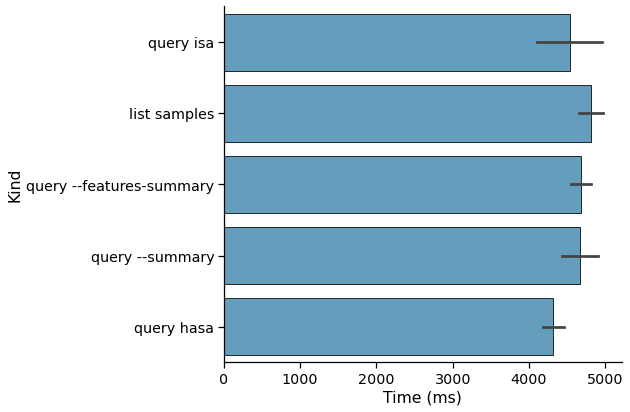

In [19]:
query_cli_samples = query_cli_df[query_cli_df['Samples'] == 100]
query_cli_samples = query_cli_samples.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=query_cli_samples, kind="bar",
                  y="Kind", x="Time (ms)", hue=None,
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")
    plt.savefig('figures/query-cli-runtime-100.pdf')

#### 3.2.1.1. Compare runtime between CLI and API

In [20]:
qcli = query_cli_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qcli['Kind'] = qcli['Kind'].replace({
        'query isa': 'isa',
        'query hasa': 'hasa',
        'query isin': 'isin',
        'query --features-summary': 'features summary',
    })
qcli['Method'] = 'CLI'
qapi = query_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qapi['Kind'] = qapi['Kind'].replace({
        'q.isa': 'isa',
        'q.hasa': 'hasa',
        'q.isin': 'isin',
        'q.features_summary': 'features summary',
    })
qapi['Method'] = 'API'

q_cli_api = pd.concat([qcli, qapi])
q_cli_api = q_cli_api[q_cli_api['Kind'].isin(['isa', 'hasa', 'isin', 'features summary'])]
q_cli_api = q_cli_api.sort_values(['Time (ms)'])
q_cli_api.head(3)

,Name,Kind,Number samples,Time (ms),Method
387,case-100,isa,100,0.536705,API
388,case-100,isa,100,0.553504,API
383,case-100,isa,100,0.556917,API


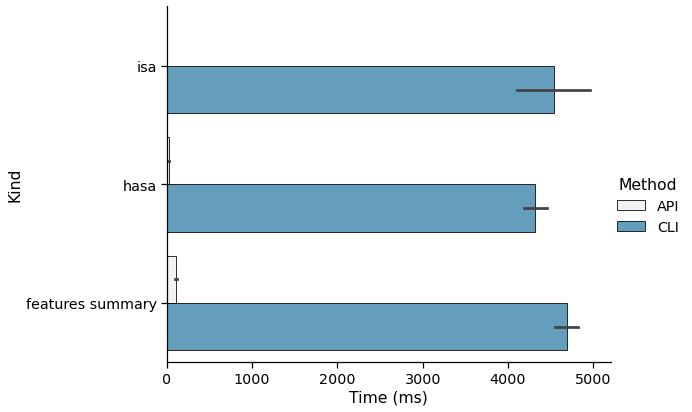

In [21]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=q_cli_api, kind="bar",
                  y="Kind", x="Time (ms)", hue='Method',
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")
    plt.savefig('figures/query-cli-api-runtime-100.pdf')

### 3.2.2. Compare runtime to number of samples

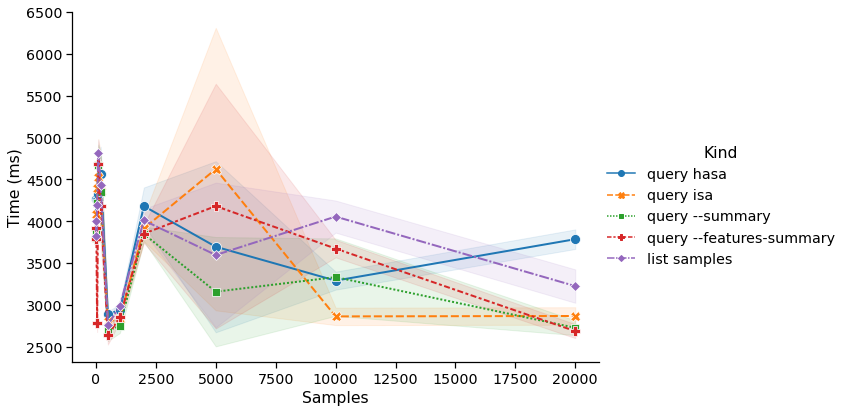

In [22]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Samples', y='Time (ms)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                     facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, style="Kind", markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-runtime.pdf')

### 3.2.3. Compare peak memory to number of samples

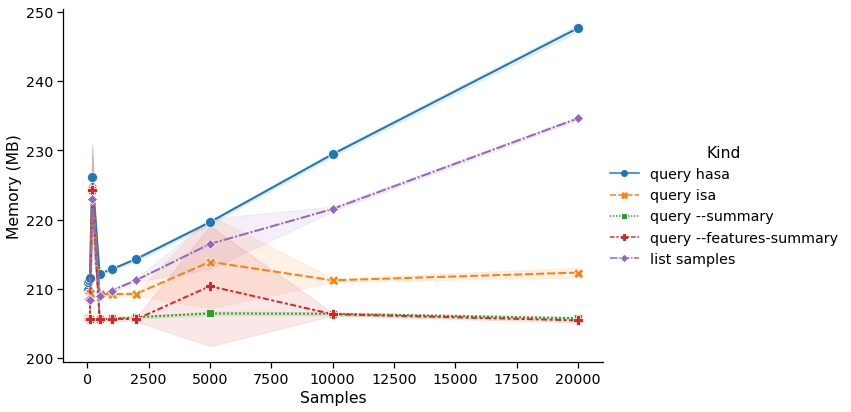

In [23]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Samples', y='Memory (MB)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                     facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Memory (MB)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-memory.pdf')

### 3.2.4. Compare runtime to number of features

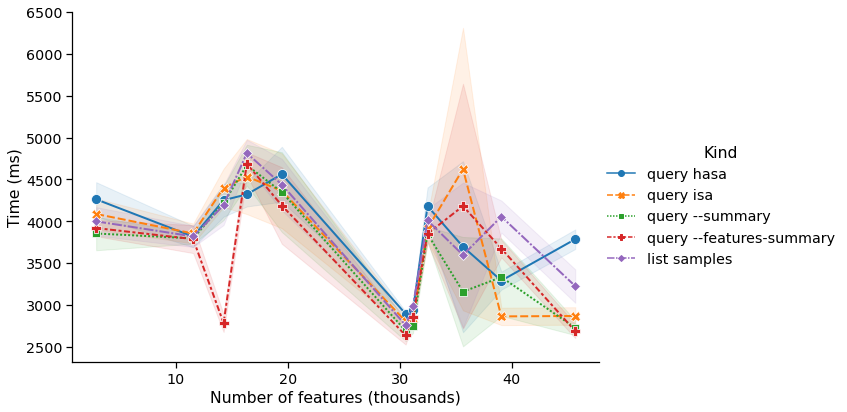

In [24]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-runtime-features.pdf')

### 3.2.5. Compare peak memory to number of features

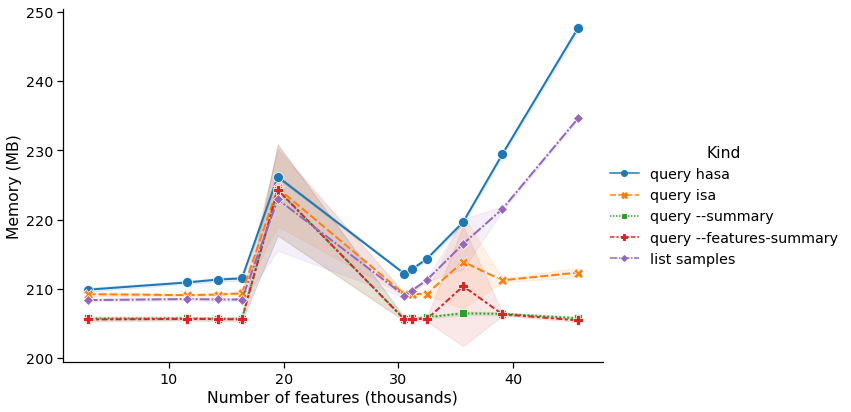

In [25]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-memory-features.pdf')

# 4. Tree vs. clustering

## 4.1. Connect to index and metadata file

In [26]:
import genomics_data_index.api as gdi

number_samples = 500
min_samples_cluster = 2

clustering_index = cases_root_dir / f'case-{number_samples}' / 'index'
db = gdi.GenomicsDataIndex.connect(clustering_index)
db

<GenomicsDataIndex(samples=500)>

In [27]:
import pandas as pd

metadata_df = pd.read_csv(metadata_file, sep='\t')
metadata_df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,OU420663,ncov,?,OU420663,ERR5939958,2020,Europe,United Kingdom,England,NaN,...,1.00000,Alpha (B.1.1.7-like),1.0,0.0,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,scorpio call: Alt alleles 23; Ref alleles 0; A...
1,USA/NY-CUIMC-NP-3606/2020,ncov,?,MZ702266,NaN,2020-12-02,North America,USA,New York,New York City,...,0.95097,NaN,NaN,NaN,PLEARN-v1.2.66,3.1.11,2021-08-24,v1.2.66,passed_qc,NaN


In [28]:
metadata_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'snp_clusters', 'QC_missing_data', 'QC_mixed_sites',
       'QC_rare_mutations', 'QC_snp_clusters', 'clock_deviation',
       'missing_data_percent', 'taxon', 'lineage', 'conflict',
       'ambiguity_score', 'scorpio_call', 'scorpio_support',
       'scorpio_conflict', 'version', 'pangolin_version', 'pangoLEARN_version',
       'pango_version', 'status', 'note'],
      dtype='object')

In [29]:
metadata_df[metadata_df['lineage'].str.match('^[^.][^.]')]['lineage'].value_counts()

AY.4      11346
None        772
AY.5        689
AY.9        554
AY.25       545
AY.3        350
AY.6        342
AY.12       334
AD.2        235
AY.7        183
AY.14       119
AY.8        108
AY.10       107
AY.2         89
AY.20        75
AY.15        53
AY.13        52
AY.11        50
AY.24        46
AY.3.1       26
AY.19        19
AY.23        18
AY.1         15
AV.1         14
AY.7.1        8
AY.16         7
AA.1          7
AP.1          5
AZ.2          5
AY.7.2        4
AY.21         4
AY.22         4
AN.1          4
AK.1          4
AS.2          3
XA            3
AE.2          3
AZ.3          3
AG.1          2
AZ.2.1        2
AA.3          1
AE.6          1
AE.7          1
AA.5          1
AU.2          1
AS.1          1
AF.1          1
AE.8          1
AZ.4          1
AA.4          1
AM.1          1
AC.1          1
Name: lineage, dtype: int64

### 4.1.1. Expand lineages so they are hierarchical

Some lineages have 2-character top-level codes which are aliases for other lineages (e.g., `AY` is an alias for `B.1.617.2`, https://cov-lineages.org/lineage_list.html). In order for my cluster comparison code to work I need to expand these lineages back to their long-form version. I am doing this here.

Note: I'm only expanding lineages I've observed in my final tree. In particular:

`AY` is an alias for `B.1.617.2` while `AV` is an alias for `B.1.1.482` (https://cov-lineages.org/lineage_list.html).

In [30]:
import re

metadata_expaneded_lineages_df = metadata_df.copy()
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^AY', r'B.1.617.2', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^AV', r'B.1.1.482', x))

metadata_expaneded_lineages_df[metadata_expaneded_lineages_df['lineage'].str.match('B.1.617.2') | 
                              metadata_expaneded_lineages_df['lineage'].str.match('B.1.1.482')]['lineage'].value_counts()

B.1.617.2.4      11346
B.1.617.2         5418
B.1.617.2.5        689
B.1.617.2.9        554
B.1.617.2.25       545
B.1.617.2.3        350
B.1.617.2.6        342
B.1.617.2.12       334
B.1.617.2.7        183
B.1.617.2.14       119
B.1.617.2.8        108
B.1.617.2.10       107
B.1.617.2.2         89
B.1.617.2.20        75
B.1.617.2.15        53
B.1.617.2.13        52
B.1.617.2.11        50
B.1.617.2.24        46
B.1.617.2.3.1       26
B.1.617.2.19        19
B.1.617.2.23        18
B.1.617.2.1         15
B.1.1.482.1         14
B.1.617.2.7.1        8
B.1.617.2.16         7
B.1.617.2.21         4
B.1.617.2.7.2        4
B.1.617.2.22         4
Name: lineage, dtype: int64

## 4.2. Initiate query

In [31]:
q = db.samples_query(reference_name='NC_045512', universe='mutations').set_outgroup('NC_045512')\
      .join(metadata_expaneded_lineages_df, sample_names_column='strain')
q

<MutationTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

## 4.3. Look over lineages in tree

In [32]:
samples_examined_df = q.toframe()
samples_examined_df['lineage'].value_counts()

B.1.1.7        122
B.1.617.2.4     64
B.1             40
D.2             36
B               22
              ... 
B.1.1.58         1
B.12             1
B.1.1.47         1
B.1.1.242        1
B.1.400          1
Name: lineage, Length: 72, dtype: int64

In [33]:
samples_examined_df[samples_examined_df['lineage'].str.match('^[^.][^.]')]['lineage'].value_counts()

None    7
Name: lineage, dtype: int64

## 4.4. Cluster scoring (ML tree)

In [34]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

def get_scores_at_lineage_level(scorer: ClusterScorer, level: int, score_label: str) -> pd.DataFrame:
    scores = scorer.score_groupby(groupby_column='lineage', min_samples_count=min_samples_cluster,
                                    groupby_func=lineage_level_group_funcs[level])
    scores = scores.rename({'Score': score_label}, axis='columns')
    scores = scores[scores.index.str.count('\.') == level]
    
    # Remove 'None' lineage scores since they aren't a valid lineage
    scores = scores[scores.index != 'None']
    
    return scores

def get_scores_grouped_by_lineage_levels(scorer: ClusterScorer, score_label: str,
                                         max_level: int) -> pd.DataFrame:
    level_dfs = []
    for level in range(max_level):
        level_dfs.append(get_scores_at_lineage_level(scorer=scorer, score_label=score_label, level=level))
    return pd.concat(level_dfs)

In [35]:
max_lineage_depth = max(map(lambda x: x.count('.') + 1, samples_examined_df['lineage'].value_counts().index.tolist()))
max_lineage_depth

5

In [36]:
import re

lineage_level_group_funcs = {
    0: lambda x: re.sub(r'^([^.]*)\..*', r'\1', x),
    1: lambda x: re.sub(r'^([^.]*\.[^.]+)\..*', r'\1', x),
    2: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+)\..*', r'\1', x),
    3: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
    4: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
}

test_lineage = 'A.1.2.3.4.5'
for i in range(max_lineage_depth):
    print(f'Level {i}: {lineage_level_group_funcs[i](test_lineage)} [{test_lineage}]')

Level 0: A [A.1.2.3.4.5]
Level 1: A.1 [A.1.2.3.4.5]
Level 2: A.1.2 [A.1.2.3.4.5]
Level 3: A.1.2.3 [A.1.2.3.4.5]
Level 4: A.1.2.3.4 [A.1.2.3.4.5]


In [37]:
scores_ml = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q), score_label='Score (ML)',
                                                 max_level=max_lineage_depth)
scores_ml

,Score (ML),Sample Count
lineage,,
A,0.036000,18
B,0.858000,429
C,1.000000,10
D,1.000000,36
A.1,1.000000,12
B.1,0.788000,394
B.3,1.000000,3
B.4,1.000000,2
B.43,1.000000,3


## 4.5. Cluster scoring (kmer trees)

### 4.5.1. Build and score 31-mer tree

In [38]:
from ete3 import Tree, ClusterTree

# Used due to a bug in the software which uses the original filenames as names in the tree instead
# of the sample names. This can be removed when the bug is fixed.
def fix_kmer_tree_names(tree: Tree) -> Tree:
    newick_str = tree.write()
    newick_fixed = newick_str.replace('__','/')
            
    return ClusterTree(newick_fixed)

In [39]:
import time

q31 = db.samples_query()
start = time.time()
q31 = q31.build_tree(kind='kmer', kmer_size=31)
end = time.time()
q31 = q31.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q31._tree = fix_kmer_tree_names(q31.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q31

Took 1.72 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [40]:
score_kmer_31 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q31), score_label='Score (kmer=31)',
                                                 max_level=max_lineage_depth)
score_kmer_31

,Score (kmer=31),Sample Count
lineage,,
A,0.036961,18
B,0.864919,429
C,0.020450,10
D,0.073770,36
A.1,0.024641,12
B.1,0.794355,394
B.3,0.009375,3
B.4,0.142857,2
B.43,0.009231,3


### 4.5.2. Build and score 51-mer tree

In [41]:
q51 = db.samples_query()
start = time.time()
q51 = q51.build_tree(kind='kmer', kmer_size=51)
end = time.time()
q51 = q51.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q51._tree = fix_kmer_tree_names(q51.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q51

Took 1.67 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [42]:
score_kmer_51 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q51), score_label='Score (kmer=51)',
                                                 max_level=max_lineage_depth)
score_kmer_51

,Score (kmer=51),Sample Count
lineage,,
A,0.037500,18
B,0.861446,429
C,0.020161,10
D,0.076433,36
A.1,0.025000,12
B.1,0.791165,394
B.3,0.017647,3
B.4,0.011765,2
B.43,0.008065,3


### 4.5.2. Build and score 71-mer tree

In [43]:
q71 = db.samples_query()
start = time.time()
q71 = q71.build_tree(kind='kmer', kmer_size=71)
end = time.time()
q71 = q71.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q71._tree = fix_kmer_tree_names(q71.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q71

Took 1.75 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [44]:
score_kmer_71 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q71), score_label='Score (kmer=71)',
                                                 max_level=max_lineage_depth)
score_kmer_71

,Score (kmer=71),Sample Count
lineage,,
A,0.036810,18
B,0.866667,429
C,0.021277,10
D,0.074689,36
A.1,0.024540,12
B.1,0.795960,394
B.3,0.011673,3
B.4,0.019048,2
B.43,0.028302,3


## 4.6. Plot cluster scores

In [45]:
from colour import Color

def color_gradient(left: Color, right: Color, number_colors: int) -> List[str]:
    return list(map(lambda x: x.hex_l, list(left.range_to(right, number_colors))))

def apply_colors_to_level(df: pd.DataFrame, left: Color = None, right: Color = None, level: int = 0,
                          colors_list: List[str] = None) -> pd.DataFrame:
    df = df.copy()
    number_colors = len(scores_df[scores_df['lineage level'] == level])
    if colors_list is not None:
        colors = colors_list
    else:
        colors = color_gradient(left=left, right=right, number_colors=number_colors)
    
    df.loc[df['lineage level'] == level, 'color'] = colors
    return df

color_gradient(left=Color('#bdbdbd'), right=Color('#636363'), number_colors=3)

['#bdbdbd', '#909090', '#636363']

In [46]:
scores_df = scores_ml.copy()
for other_df in [score_kmer_31, score_kmer_51, score_kmer_71]:
    other_df = other_df.drop(['Sample Count'], axis='columns')
    scores_df = scores_df.merge(other_df, left_index=True, right_index=True)
scores_df = scores_df.reset_index()
scores_df['lineage level'] = scores_df['lineage'].str.count('\.')

# Add colors based on a gradient
scores_df = apply_colors_to_level(scores_df, left=Color('#f7f7f7'), right=Color('#525252'), level=0)
scores_df = apply_colors_to_level(scores_df, left=Color('#eff3ff'), right=Color('#2171b5'), level=1)
scores_df = apply_colors_to_level(scores_df, left=Color('#fee5d9'), right=Color('#cb181d'), level=2)
scores_df = apply_colors_to_level(scores_df, left=Color('#edf8e9'), right=Color('#238b45'), level=3)
scores_df = apply_colors_to_level(scores_df, left=Color('#f2f0f7'), right=Color('#6a51a3'), level=4)

# Override top-level colors since there's so few and I want them to be different hues
colors_list_0 = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4']
scores_df = apply_colors_to_level(scores_df, colors_list=colors_list_0, level=0)

scores_df

,lineage,Score (ML),Sample Count,Score (kmer=31),Score (kmer=51),Score (kmer=71),lineage level,color
0,A,0.036000,18,0.036961,0.037500,0.036810,0,#b3e2cd
1,B,0.858000,429,0.864919,0.861446,0.866667,0,#fdcdac
2,C,1.000000,10,0.020450,0.020161,0.021277,0,#cbd5e8
3,D,1.000000,36,0.073770,0.076433,0.074689,0,#f4cae4
4,A.1,1.000000,12,0.024641,0.025000,0.024540,1,#eff3ff
5,B.1,0.788000,394,0.794355,0.791165,0.795960,1,#c2d4fd
6,B.3,1.000000,3,0.009375,0.017647,0.011673,1,#97b9f9
7,B.4,1.000000,2,0.142857,0.011765,0.019048,1,#6fa3f3
8,B.43,1.000000,3,0.009231,0.008065,0.028302,1,#4991ea
9,C.35,1.000000,9,0.018405,0.018145,0.019149,1,#2681df


In [47]:
scores_long_df = pd.melt(scores_df, id_vars='lineage',
                         value_vars=['Score (ML)', 'Score (kmer=31)', 'Score (kmer=51)', 'Score (kmer=71)'])
scores_long_df = scores_long_df.rename({'lineage': 'Lineage', 'variable': 'Method', 'value': 'Score'}, axis='columns')
scores_long_df.head(3)

,Lineage,Method,Score
0,A,Score (ML),0.036
1,B,Score (ML),0.858
2,C,Score (ML),1.000


In [48]:
scores_long_df.groupby('Method').agg('median')

,Score
Method,
Score (ML),1.000000
Score (kmer=31),0.027047
Score (kmer=51),0.052178
Score (kmer=71),0.038754


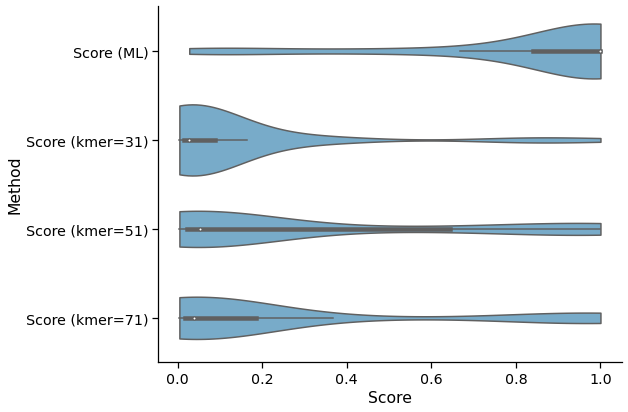

In [49]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=scores_long_df, kind="violin",
                    y="Method", x="Score", hue=None,
                    scale='area', inner='box',
                    ci=None, height=6, aspect=1.5,
                    cut=0,
                    color="#6baed6", edgecolor="black")
    plt.savefig('figures/tree-clustering-500.pdf')

## 4.7 Visualize clusters

In [50]:
from genomics_data_index.api.viewer.TreeStyler import TreeStyler, HighlightStyle
from genomics_data_index.api.query.SamplesQuery import SamplesQuery
from typing import List, Dict, Tuple

def highlight_lineages(ts: TreeStyler, query: SamplesQuery, lineage_labels: Dict[str, str]) -> TreeStyler:
    for lineage in lineage_labels:
        label = lineage_labels[lineage]
        ts = ts.highlight(query.isa(fr'^{lineage}', isa_column='lineage', kind='dataframe', regex=True),
                          legend_label=label)
    return ts

def annotate_lineages(ts: TreeStyler, query: SamplesQuery, lineages: List[str], colors: List[str] = None,
                     no_labels: bool = True) -> TreeStyler:
    if colors is None:
        colors = map(lambda x: 'black', lineages)
    for lineage, color in zip(lineages, colors):
        if no_labels:
            ts = ts.annotate(query.isa(fr'^{lineage}', isa_column='lineage', kind='dataframe', regex=True),
                 color_present=color)
        else:
            ts = ts.annotate(query.isa(fr'^{lineage}', isa_column='lineage', kind='dataframe', regex=True),
                 legend_label=lineage, color_present=color)

    return ts

def annotate_all_lineage_levels(ts: TreeStyler, query: SamplesQuery, scores_df: pd.DataFrame) -> TreeStyler:
    lineage_levels = scores_df['lineage level'].value_counts().index.tolist()
    lineage_levels.sort()
    for level in lineage_levels:
        lineages = scores_df.loc[scores_df['lineage level'] == level, 'lineage'].tolist()
        colors = scores_df.loc[scores_df['lineage level'] == level, 'color'].tolist()       
        ts = annotate_lineages(ts, query=q, lineages=lineages, colors=colors)
        
    return ts

def create_highlight_style(scores_df: pd.DataFrame, level: int) -> HighlightStyle:
    fg_colors = scores_df.loc[scores_df['lineage level'] == level, 'color'].tolist()
    bg_colors = fg_colors
    unknown_fg_color = 'lightgray'
    unknown_bg_color = 'lightgray'
    return HighlightStyle._create_highlights(fg_colors=fg_colors, bg_colors=bg_colors,
                                  unknown_bg_color=unknown_bg_color, unknown_fg_color=unknown_fg_color)

def create_lineage_data(scores_df: pd.DataFrame, 
                        score_column: str) -> Tuple[Dict[str,str], List[str], List[str]]:
    lineage_labels_dict = {}
    lineages_dict = {}
    colors_dict = {}
    for level in range(max_lineage_depth):
        lineages_dict[level] = scores_df.loc[scores_df['lineage level'] == level, 'lineage'].tolist()
        colors_dict[level] = scores_df.loc[scores_df['lineage level'] == level, 'color'].tolist()

        lineage_labels_dict[level] = {
            l: f'{l} (score={scores_df.loc[scores_df["lineage"] == l, score_column].values[0]:0.2f})' 
            for l in lineages_dict[level]}
    
    return lineage_labels_dict, lineages_dict, colors_dict

In [51]:
top_lineages_ml = scores_df.sort_values(['Score (ML)', 'Sample Count'], ascending=False).head(5)
top_lineages_ml

,lineage,Score (ML),Sample Count,Score (kmer=31),Score (kmer=51),Score (kmer=71),lineage level,color
3,D,1.0,36,0.073770,0.076433,0.074689,0,#f4cae4
10,D.2,1.0,36,0.073770,0.076433,0.074689,1,#2171b5
14,B.1.177,1.0,30,0.067416,0.080000,0.093168,2,#c4fba4
27,B.1.1.39,1.0,13,0.028953,0.027542,0.028322,3,#c5ebbe
4,A.1,1.0,12,0.024641,0.025000,0.024540,1,#eff3ff


### 4.7.1. Visualize ML scores

#### 4.7.1.1. On ML tree

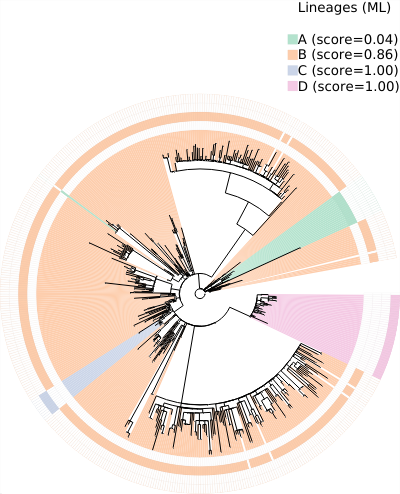

In [52]:
lineage_labels_dict, lineages_dict, colors_dict = create_lineage_data(scores_df=scores_df, score_column="Score (ML)")
display_level = 0

highlight_style = create_highlight_style(scores_df, level=display_level)

ts = q.tree_styler(mode='c', highlight_style=highlight_style,
                   legend_nsize=500, legend_fsize=500,
                   annotate_opacity_absent=1.0,
                   annotate_border_width=1,
                   annotate_box_width=450, annotate_box_height=100,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Lineages (ML)', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   show_leaf_names=False, annotate_guiding_lines=False,
                  )

ts = highlight_lineages(ts, query=q,
                        lineage_labels=lineage_labels_dict[display_level])
ts = annotate_lineages(ts, query=q,
                        lineages=lineages_dict[display_level], colors=colors_dict[display_level])
x = ts.render('figures/ml-tree-clusters.png', w=1600)
ts.render(w=400)

#### 4.7.1.2. On kmer=51 tree

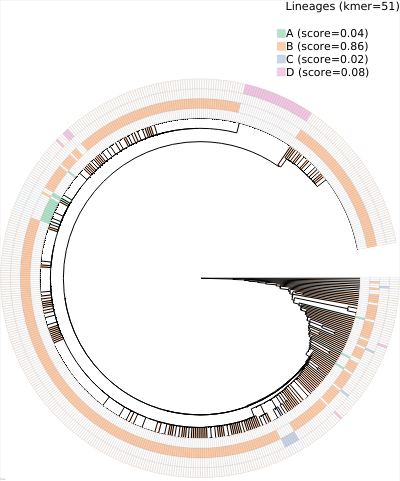

In [53]:
ts51 = q51.tree_styler(mode='c', highlight_style=highlight_style,
                   annotate_box_width=150, legend_nsize=125, legend_fsize=125,
                   annotate_opacity_absent=1.0,
                   legend_type_label_present='', legend_type_label_unknown='',
                   legend_title='Lineages (kmer=51)', annotate_show_box_label=False,
                   include_unknown=False, annotate_color_unknown='black',
                   show_leaf_names=False, annotate_guiding_lines=False)

lineage_labels_dict, lineages_dict, colors_dict = create_lineage_data(scores_df=scores_df, score_column="Score (kmer=51)")

ts51 = highlight_lineages(ts51, query=q51,
                        lineage_labels=lineage_labels_dict[display_level])
ts51 = annotate_lineages(ts51, query=q51,
                        lineages=lineages_dict[display_level], colors=colors_dict[display_level])
x = ts51.render('figures/kmer51-tree-clusters.png', w=1600)
ts51.render(w=400)